In [1]:
# The Visual Transformer Autoencoder did not work
# THis notebook runs a test to see if it can identify any patch, that is, any location, 
# or if it cannot distinguish the patches.

# I expect that this test will fail initially, and succeed once I have fixed the underlying issue

In [2]:
from visual_transformer import *

In [3]:
# There is no cuda:1 on the smaller penguins.farm
device = torch.device('cuda') #torch.device('cuda:1') # the big machine

In [4]:
brain = DefaultAgentBrain().to(device)

In [5]:
224 / 16

14.0

In [6]:
def get_batch(batchsize=4):
    res = torch.ones((batchsize, 3, 224, 224), device=device)
    res[:, :, :3*14, :3*14] = 0
    return res

In [7]:
import matplotlib.pyplot as plt

In [8]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

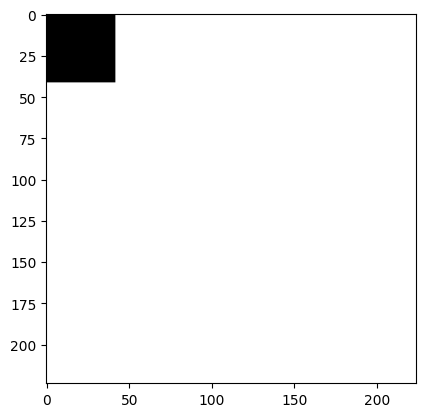

In [9]:
sample = get_batch()
quick_display(sample[3])

In [10]:
# now, will the brain learn to produce this image? Or merely splatter gray all over the canvas?

In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = optim.Adam(brain.parameters(), lr=0.001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)

In [13]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()
for b in range(total_batches):
    if b == 0:
        start = time.time()
    #img_set = G.random_full_image_set(restrict_angles=True)
    #img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    img_tensor = get_batch()
    batch_size = img_tensor.size()[0]
    text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor, text_context)
    loss = criterion(recon, img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), 'brain_checkpoints/img_encoder_weights_DEBUG.pth')
        torch.save(brain.img_dec.state_dict(), 'brain_checkpoints/img_decoder_weights_DEBUG.pth')

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 2.7568540573120117 seconds
Avg loss for last 100 batches, at batch 100: 0.11863768219947815
Avg loss for last 100 batches, at batch 200: 0.046304205544292924
Avg loss for last 100 batches, at batch 300: 0.03606459576636553
Avg loss for last 100 batches, at batch 400: 0.03550341013818979
Avg loss for last 100 batches, at batch 500: 0.03521875474601984
Avg loss for last 100 batches, at batch 600: 0.03501767914742231
Avg loss for last 100 batches, at batch 700: 0.03487846426665783
Avg loss for last 100 batches, at batch 800: 0.03476387195289135
Avg loss for last 100 batches, at batch 900: 0.03476492937654257
Avg loss for last 100 batches, at batch 1000: 0.034612258560955525
Avg loss for last 100 batches, at batch 1100: 0.03460289400070906
Avg loss for last 100 batches, at batch 1200: 0.03449152939021587
Avg loss for last 100 batches, at batch 1300: 0.03447504706680775
Avg loss for last 100 batches, at batch 1400: 0.03443450950086117
Avg loss for last 100 batches, at batc

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.90268135..1.0284889].


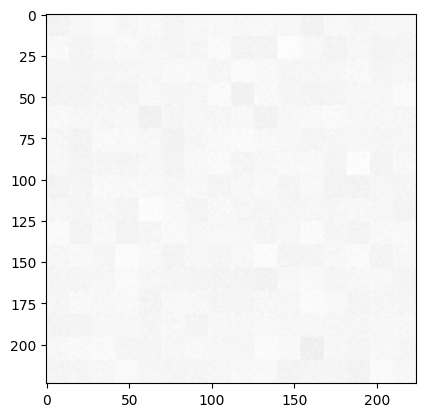

In [15]:
quick_display(recon[1])

In [16]:
# Precisely as expected.

In [17]:
sample[0]

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [18]:
p_embedded = brain.img_enc.embed[0](sample)

In [19]:
p_embedded.size()

torch.Size([4, 256, 768])

In [20]:
p_embedded[0, :4, :4]

tensor([[ 0.0078,  0.0264,  0.0070, -0.0233],
        [ 0.0078,  0.0264,  0.0070, -0.0233],
        [ 0.0078,  0.0264,  0.0070, -0.0233],
        [ 3.8390, -3.2872, -3.8896,  3.0400]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [21]:
pos_embedded = brain.img_enc.embed[1](p_embedded)

In [22]:
pos_embedded[0, :4, :4]

tensor([[ 1.2170e+00,  1.5028e+00, -1.4710e-01, -6.4007e-01],
        [-4.5279e-01,  5.1027e-01, -1.6566e-02, -8.0823e-01],
        [-3.7977e-01,  1.3685e+00,  2.3176e-01, -1.0163e+00],
        [ 1.0603e+02, -9.0468e+01, -1.0704e+02,  8.4872e+01]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [23]:
# Good start.
# Further work: check to make sure that what's being added is added correctly, in the right places, etc.

# Made sure it's correct? Switch to copying someone else's approach.